**Import**

In [ ]:
pip install FlowCytometryTools

     |████████████████████████████████| 11.9MB 261kB/s 
     |████████████████████████████████| 4.7MB 35.0MB/s 
  Created wheel for FlowCytometryTools: filename=FlowCytometryTools-0.5.0-cp36-none-any.whl size=11921188 sha256=1ff19dc63cb4fa5490f3f24bc01925970f14c347346e873390f43213f186118b
  Stored in directory: /root/.cache/pip/wheels/b5/fa/c4/65df5b4cb24a578b4822e21daa7c6bb5de6d507945dc768149
Successfully built FlowCytometryTools


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from FlowCytometryTools import FCMeasurement
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/FlowCytometryTools/core/docstring.py:56: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  doc = dedent(doc)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Helper** **functions**

In [ ]:
def summorize_fcs(meta, data_path): 
    files = list(meta.file_name)
    status = list(meta.condition)
    samp = list(meta.sample_id)
    #open the first file to retrieve the order of markers
    sample = FCMeasurement(ID='Sample', datafile=data_path +files[0])
    dat1 = sample.data
    genes = dat1.columns
    genes = [x.split("_")[1] for x in genes]

    # matrix with medians for each marker and each sample
    medians_full = np.zeros((len(genes), len(samp)))
    # dictionary with medians for each sample and each condition
    medians_cond = dict()

    # file processing is performed per marker to avoid loading too much data into memory
    for i in range(len(genes)):
        gene = genes[i]
        old = 0
        for j in range(len(files)):
            st = status[j]
            file = files[j]
            gr = samp[j]
            sample = FCMeasurement(ID='Sample', datafile=data_path +file)
            dat1 = sample.data
            gs = dat1.columns
            genes_new = [x.split("_")[1] for x in gs]
            dat1.columns = genes_new
            new_dat = dat1[[gene]]
            new_dat.columns = ["expression"]
            new_dat["group"] = [gr]*dat1.shape[0]
            new_dat["antibody"] = [gene]*dat1.shape[0]
            new_dat["status"] = [st]*dat1.shape[0]
            new_dat.index = np.arange(old,dat1.shape[0]+old)
            old = dat1.shape[0] + old
            if j == 0:
                all_dat = new_dat.copy()
            else:    
                all_dat = pd.concat([all_dat, new_dat])
        #data transformation
        all_dat.expression = np.arcsinh(all_dat.expression/5)
        #medians for healthy and patients
        hp = all_dat['expression'][all_dat['status'] == 'healthy']
        cp = all_dat['expression'][all_dat['status'] == 'patient']
        medians_cond[gene] = [np.median(hp), np.median(cp)]
        #medians for each sample
        for j in range(len(samp)):
            s = samp[j]
            condition = (all_dat['group'] == s) 
            vals = all_dat['expression'][condition]
            medians_full[i,j] = np.median(vals)
    medians_full = pd.DataFrame(medians_full, index = genes, columns = samp)
    return(medians_full, medians_cond)


def pv_estimate(dat, markers, model):
    pvs = []
    for m in markers:
        d = dat[dat.marker == m]
        md = smf.mixedlm(model,d ,
                     groups=d["samples"])
        try:
            mdf = md.fit()

            pvs.append((m,mdf.pvalues[1]))
        except np.linalg.LinAlgError:
            pvs.append((m,np.nan))
    # for correction we save only those p-values that were actually computed and did not crash due to 0 variance
    ms = []
    ps = []
    for g,p in pvs:
        if not np.isnan(p):
            ps.append(p)
            ms.append(g)
    #FDR correction
    _, new_pv = sm.stats.fdrcorrection(ps, alpha=0.05, method='indep', is_sorted=False)
    result = dict()
    for i in range(len(new_pv)):
        result[ms[i]] = new_pv[i]
    return(result)

**Reading and summorizing the data**

1.1 Not activated samples metadata

In [ ]:
meta_na = pd.read_excel(r'/content/meta_healthy_dual_baseline.xlsx', sheet_name="Sheet1")
display(meta_na)

,file_name,sample_id,condition,patient_id
0,CVD001B_platlet_specific_viSNE.fcs_platlet spe...,CVD001B,healthy,CVD001B
1,CVD003B_platlet_specific_viSNE.fcs_platlet spe...,CVD003B,healthy,CVD003B
2,CVD006B_platlet_specific_viSNE.fcs_platlet spe...,CVD006B,healthy,CVD006B
3,CVD007B_platlet_specific_viSNE.fcs_platlet spe...,CVD007B,healthy,CVD007B
4,CVD010B_platlet_specific_viSNE.fcs_platlet spe...,CVD010B,healthy,CVD010B
5,CVD011B_platlet_specific_viSNE.fcs_platlet spe...,CVD011B,healthy,CVD011B
6,CVD012B_platlet_specific_viSNE.fcs_platlet spe...,CVD012B,healthy,CVD012B
7,CVD013B_platlet_specific_viSNE.fcs_platlet spe...,CVD013B,healthy,CVD013B
8,CVD019B_platlet_specific_viSNE.fcs_platlet spe...,CVD019B,healthy,CVD019B
9,CVD020B_platlet_specific_viSNE.fcs_platlet spe...,CVD020B,healthy,CVD020B


In [ ]:
files = r'/content/output baseline/'
medians_full_na, medians_cond_na = summorize_fcs(meta_na, files)

medians_full_na.to_csv(r'/content/medians_na.csv', index=True)

1.2. Activated samples metadata

In [ ]:
meta_act = pd.read_excel(r'/content/meta_healthy_dual_activated.xlsx', sheet_name="Sheet1")
display(meta_act)

,file_name,sample_id,condition,patient_id
0,CVD001A_platlet_specific_viSNE.fcs_platlet spe...,CVD001A,healthy,CVD001A
1,CVD003A_platlet_specific_viSNE.fcs_platlet spe...,CVD003A,healthy,CVD003A
2,CVD006A_platlet_specific_viSNE.fcs_platlet spe...,CVD006A,healthy,CVD006A
3,CVD007A_platlet_specific_viSNE.fcs_platlet spe...,CVD007A,healthy,CVD007A
4,CVD010A_platlet_specific_viSNE.fcs_platlet spe...,CVD010A,healthy,CVD010A
5,CVD011A_platlet_specific_viSNE.fcs_platlet spe...,CVD011A,healthy,CVD011A
6,CVD012A_platlet_specific_viSNE.fcs_platlet spe...,CVD012A,healthy,CVD012A
7,CVD013A_platlet_specific_viSNE.fcs_platlet spe...,CVD013A,healthy,CVD013A
8,CVD019A_platlet_specific_viSNE.fcs_platlet spe...,CVD019A,healthy,CVD019A
9,CVD020A_platlet_specific_viSNE.fcs_platlet spe...,CVD020A,healthy,CVD020A


In [ ]:
files = "/content/output activated/"
medians_full_act, medians_cond_act = summorize_fcs(meta_act, files)

medians_full_act.to_csv(r'/content/medians_act.csv', index=True)

In [ ]:
med_na = pd.read_csv("/content/medians_na.csv")
med_na = med_na.set_index("Unnamed: 0")
np.allclose(med_na.values, medians_full_na.values)

True

In [ ]:
medians_full_na = med_na
med_act = pd.read_csv("/content/medians_act.csv")
med_act = med_act.set_index("Unnamed: 0")
medians_full_act = med_act

1.3 Concatinating both datasets together for further analysis

In [ ]:
meta = pd.concat([meta_na,meta_act], ignore_index=True)
markers = medians_full_na.index
samples = medians_full_na.columns
conditions = [list(meta_na.condition[meta_na.sample_id == x])[0] for x in samples]

last_i = 0
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_na.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["not activated"]*dat1.shape[0]
    if i == 0:
        dat = dat1
    else:
        dat = pd.concat([dat,dat1])

markers = medians_full_act.index
samples = medians_full_act.columns
conditions = [list(meta_act.condition[meta_act.sample_id == x])[0] for x in samples]        
for i in range(len(markers)):
    m = markers[i]
    dat1 = medians_full_act.loc[[m]].T
    dat1.columns = ["expression"]
    dat1["samples"] = dat1.index
    dat1.index= np.arange(last_i,dat1.shape[0]+last_i)
    last_i = dat1.shape[0] +last_i
    dat1["marker"] = [m]*dat1.shape[0]
    dat1["condition"] = conditions
    dat1["type"] = ["activated"]*dat1.shape[0]

    dat = pd.concat([dat,dat1])

In [ ]:
dat.head()

,expression,samples,marker,condition,type
0,1.581150,CVD001B,CD41 (v),healthy,not activated
1,2.618363,CVD003B,CD41 (v),healthy,not activated
2,0.490478,CVD006B,CD41 (v),healthy,not activated
3,1.809196,CVD007B,CD41 (v),healthy,not activated
4,1.606624,CVD010B,CD41 (v),healthy,not activated


In [ ]:
dat

,expression,samples,marker,condition,type
0,1.581150,CVD001B,CD41 (v),healthy,not activated
1,2.618363,CVD003B,CD41 (v),healthy,not activated
2,0.490478,CVD006B,CD41 (v),healthy,not activated
3,1.809196,CVD007B,CD41 (v),healthy,not activated
4,1.606624,CVD010B,CD41 (v),healthy,not activated
...,...,...,...,...,...
1007,3.537567,RPs101A,CD42a (v),patient,activated
1008,3.533763,RPs103A,CD42a (v),patient,activated
1009,2.754467,RPS124A,CD42a (v),patient,activated
1010,4.103384,RPs150A,CD42a (v),patient,activated


**Differential marker expression**
1. Not activated samples

In [ ]:
warnings.filterwarnings("ignore")
markers  = list(medians_full_na.index)
model = "expression ~ condition"
results_na = pv_estimate(dat[dat.type == "not activated"], markers, model)
results_na

{'CD107a': 0.8617919843979797,
 'CD141': 0.7104280221869732,
 'CD154': 0.2652038197629573,
 'CD29 (v)': 0.7361280704313617,
 'CD3': 0.5079692631806809,
 'CD31 (v)': 0.7104280221869732,
 'CD36 (v)': 0.2652038197629573,
 'CD40': 0.5079692631806809,
 'CD41 (v)': 0.33111605203734745,
 'CD42a (v)': 0.000384160400566963,
 'CD42b (v)': 0.4608033844518004,
 'CD45': 0.0,
 'CD47 (v)': 0.7361280704313617,
 'CD61 (v)': 0.7501275033566334,
 'CD62P (v)': 0.7361280704313617,
 'CD63 (v)': 0.8731958811346185,
 'CD69 (v)': 0.677457571985056,
 'CD9 (v)': 0.7361280704313617,
 'GPVI (v)': 0.5079692631806809,
 'PAC1 (v)': 0.12892353026767367,
 'PAR1 (v)': 0.0,
 'PEAR (v)': 1.7466370517328537e-06}

In [ ]:
#act_m = ["CD63", "CD107a", "CD62P", "CD154"]
act_m = ["CD63 (v)", "CD107a", "CD62P (v)", "CD154"]
panel = list(set(markers).difference(set(act_m)))

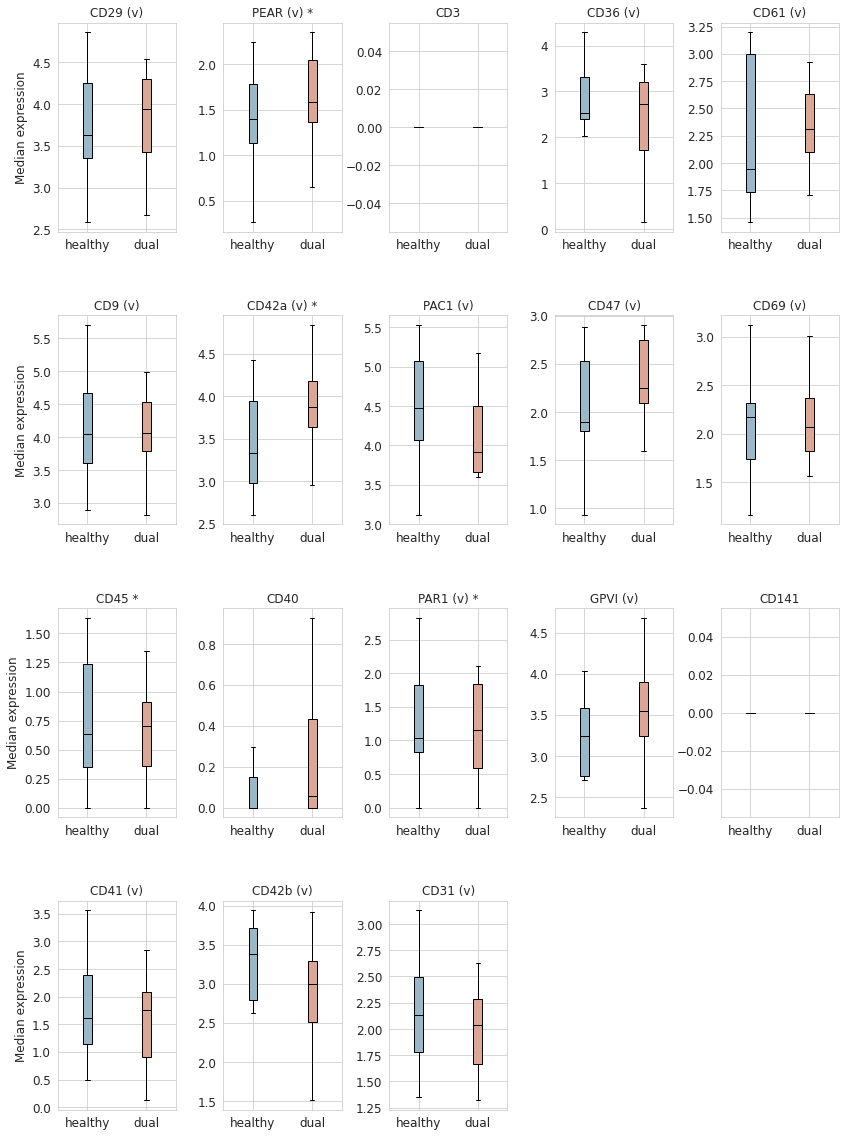

In [ ]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
markers = panel

for i in range(len(panel)):
    ax = fig.add_subplot(4, 5, i+1)
    m= markers[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")]["expression"])
   
    bp = ax.boxplot([d1,d2], labels = ["healthy", "dual"], patch_artist=True, showfliers=False)
    
    if results_na.get(m)!=None:
        if results_na[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i %5 ==  0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/all_markers_baseline.pdf",dpi = 350)
    
plt.show()

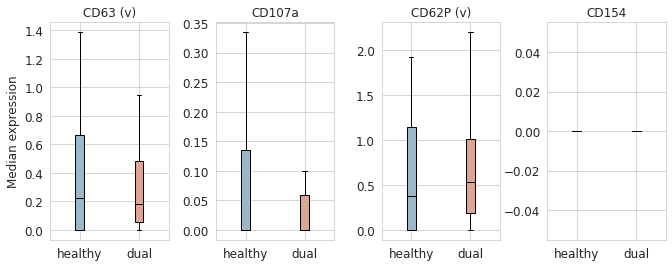

In [ ]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)

for i in range(len(act_m)):
    ax = fig.add_subplot(1, 5, i+1)
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")]["expression"])
    bp = ax.boxplot([d1,d2], labels = ["healthy", "dual"], patch_artist=True, showfliers=False)
    if results_na.get(m)!=None:
        if results_na[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i == 0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/activation_markers_baseline.pdf",dpi = 350)
    
plt.show()

2. Activated samples

In [ ]:
warnings.filterwarnings("ignore")
model = "expression ~ condition"
results_act = pv_estimate(dat[dat.type == "activated"], markers, model)
results_act

{'CD29 (v)': 0.46309539700839597,
 'CD31 (v)': 0.107686426654207,
 'CD36 (v)': 0.11085054702259449,
 'CD40': 0.002127196777221097,
 'CD41 (v)': 0.11085054702259449,
 'CD42a (v)': 0.04663245526906198,
 'CD42b (v)': 0.19437329662947325,
 'CD45': 0.9831549106144514,
 'CD47 (v)': 0.5060316017709363,
 'CD61 (v)': 0.19437329662947325,
 'CD69 (v)': 0.9831549106144514,
 'CD9 (v)': 0.9831549106144514,
 'GPVI (v)': 0.11085054702259449,
 'PAC1 (v)': 0.011755135565589787,
 'PAR1 (v)': 0.5060316017709363,
 'PEAR (v)': 0.9831549106144514}

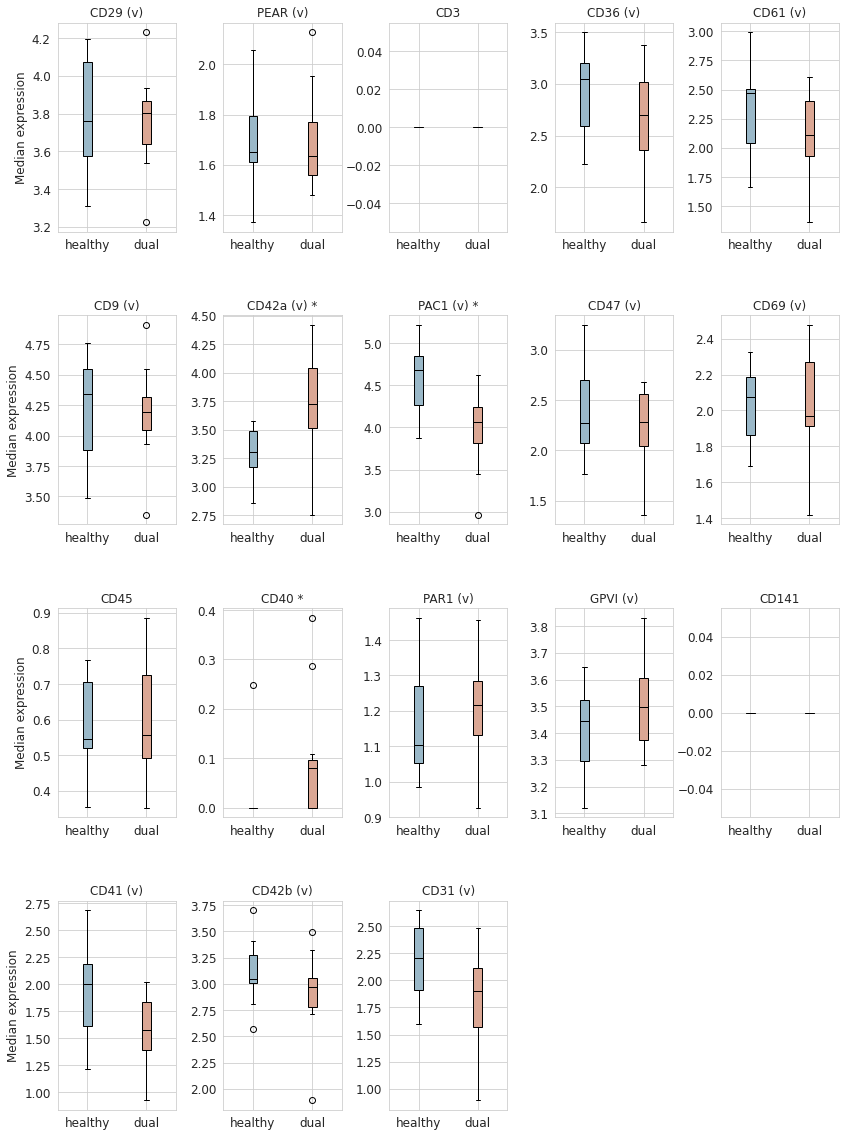

In [ ]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)

for i in range(len(panel)):
    ax = fig.add_subplot(4, 5, i+1)
    m= panel[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")]["expression"])
   
    bp = ax.boxplot([d1,d2], labels = ["healthy", "dual"], patch_artist=True)
    if results_act.get(m)!=None:
        if results_act[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i %5 ==  0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/all_markers_activated.pdf",dpi = 350)
    
plt.show()

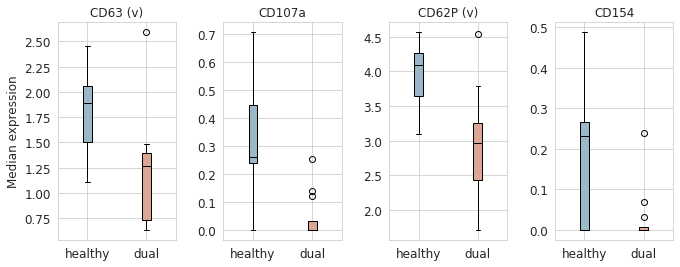

In [ ]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)
for i in range(len(act_m)):
    ax = fig.add_subplot(1, 5, i+1)
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")]["expression"])
   
    bp = ax.boxplot([d1,d2], labels = ["healthy", "dual"], patch_artist=True)
    if results_act.get(m)!=None:
        if results_act[m]<0.05:
            ax.set_title(m+" *")
        else:
            ax.set_title(m)
    else:       
        ax.set_title(m)    
    
    colors = ['#9AB8C8', '#DBA794']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color="black")
    if i == 0:
        
        ax.set_ylabel('Median expression')
#plt.savefig("vectors/activation_markers_activated.pdf",dpi = 350)

plt.show()

3. Analysis of activated and not activated samples together (aggregated in one linear model)

In [ ]:
warnings.filterwarnings("ignore")
model = "expression ~ condition + type"
results_all = pv_estimate(dat, markers, model)
results_all

{'CD141': 0.7237360337574588,
 'CD29 (v)': 0.9588657886962023,
 'CD3': 0.3086641648616167,
 'CD31 (v)': 0.08961804325818651,
 'CD36 (v)': 0.11938319983100826,
 'CD40': 0.4153487340896278,
 'CD41 (v)': 0.04912620327229807,
 'CD42a (v)': 1.15250028028205e-05,
 'CD42b (v)': 0.13546141218200047,
 'CD45': 0.7237360337574588,
 'CD47 (v)': 0.6036590850332673,
 'CD61 (v)': 0.6277398241911569,
 'CD69 (v)': 0.9098423772785715,
 'CD9 (v)': 0.7237360337574588,
 'GPVI (v)': 0.3086641648616167,
 'PAC1 (v)': 0.0017300511147791753,
 'PAR1 (v)': 0.8539468700669717,
 'PEAR (v)': 0.6036590850332673}

**Activation slope analysis**

In [ ]:
dat["patient"] = [x[:-1] for x in dat["samples"]]
ylims = {"CD63 (v)": (0,3), "CD107a": (-0.1,1.1), "CD62P (v)": (0, 5.6), "CD154": (-0.2,0.6)}

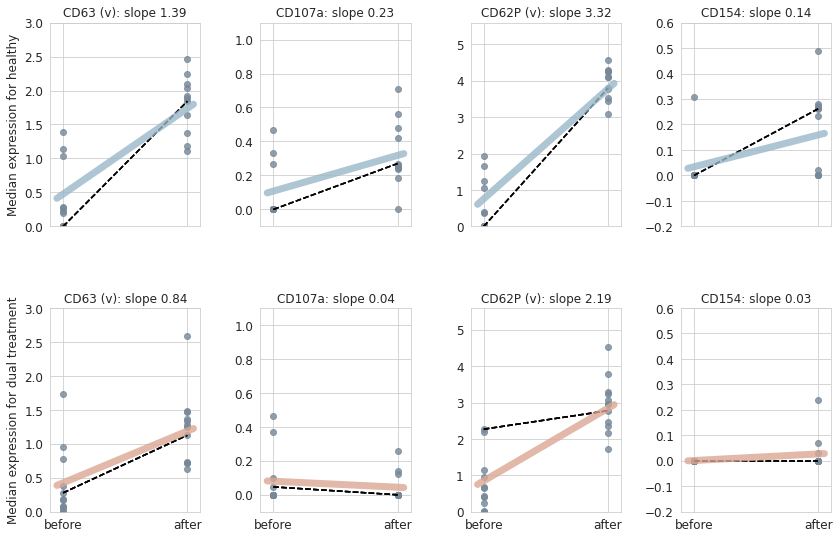

In [ ]:
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(14, 9))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plt.rc('font', size=12)  # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title
plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=12)

# top panel: only healthy
patients = list(set(dat[dat.condition == "healthy"]["patient"]))    
colors = ['#9AB8C8', '#DBA794']
for i in range(len(act_m)):
    ax = fig.add_subplot(2, 4, i+1)
    act_m = ["CD63 (v)", "CD107a", "CD62P (v)", "CD154"]
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")]["expression"])
    #plot scatter for each marker
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#778899", alpha = 0.8)
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#778899", alpha = 0.8)
    # compute the slope
    d = dat[(dat.marker == m)&(dat.condition == "healthy")]
    md = smf.mixedlm("expression ~ type",d ,
                groups=d["samples"])
    mdf = md.fit()
    # print the slope in the plot title
    ax.set_title("{0}: slope {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2)))
    # make y lable for the most left plot
    if i == 0:
        ax.set_ylabel('Median expression for healthy')
    # for each pair of patients plot a line from not activated sample to activated
    for p in patients:
        p1 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "not activated")]["expression"])[0]

        p2 = list(dat[(dat.marker == m)&(dat.condition == "healthy")& (dat.type == "activated")]["expression"])[0]

        
        plt.plot([1,2],[p1,p2], c = "black", linestyle = "--", alpha = 0.3)
    # plot the regression fit
    plt.sca(ax)
    plt.xticks([1,2], [' ', ' '])
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    plt.plot(np.array(ax.get_xlim()),ys, c = '#9AB8C8', linestyle = "-", alpha = 0.8, linewidth=7)
    plt.ylim(ylims[m])
    
    
# same actions for patients on the bottom panel    
    
patients = list(set(dat[dat.condition == "patient"]["patient"]))    
for i in range(len(act_m)):
    ax = fig.add_subplot(2, 4, i+1+ len(act_m))
    act_m = ["CD63 (v)", "CD107a", "CD62P (v)", "CD154"]
    m= act_m[i]
    d1 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")]["expression"])
    d2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")]["expression"])    
    s1 = ax.scatter(np.ones(len(d1)),d1, c = "#778899", alpha = 0.8)
    s2 = ax.scatter(np.ones(len(d1))*2,d2, c = "#778899", alpha = 0.8)
    d = dat[(dat.marker == m) & (dat.condition == "patient")]
    md = smf.mixedlm("expression ~ type",d ,
                 groups=d["samples"])
    mdf = md.fit()

    ax.set_title("{0}: slope {1}".format(m, np.round(np.abs(list(mdf.params)[1]),2)))
    

    if i == 0:
        ax.set_ylabel('Median expression for dual treatment')
    for p in patients:
        p1 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "not activated")]["expression"])[0]

        p2 = list(dat[(dat.marker == m)&(dat.condition == "patient")& (dat.type == "activated")]["expression"])[0]

        
        plt.plot([1,2],[p1,p2], c = "black", linestyle = "--", alpha = 0.3)
    
    xs = [1,0]
    b0 = mdf.params[0]
    b1 = mdf.params[1]
    ys = [b0 + b1*x for x in xs]
    plt.plot(np.array(ax.get_xlim()),ys, c = '#DBA794', linestyle = "-", alpha = 0.8,linewidth=7)
    plt.sca(ax)
    plt.xticks([1,2], ['before', 'after'])
    plt.ylim(ylims[m])

#plt.savefig("vectors/activation_all_together.pdf",dpi = 350)
plt.show()


**UMAP based on pre-computed**

1. Not activated UMAP

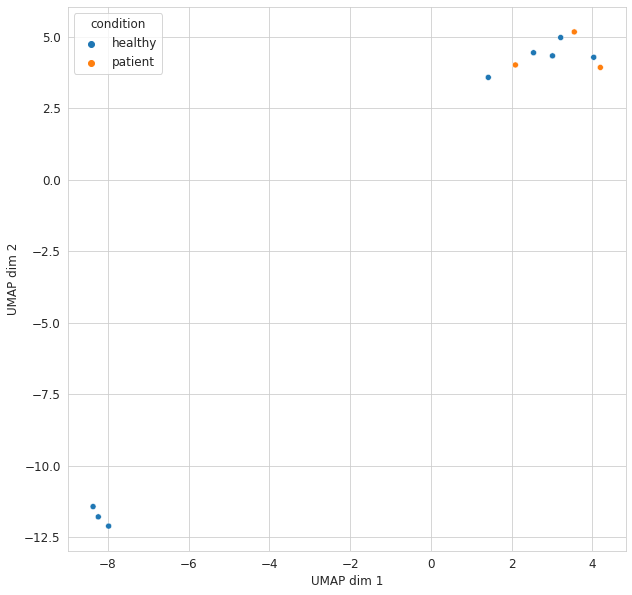

In [ ]:
umap = pd.read_csv("/content/umap_baseline.csv")
sns.set_style("whitegrid")
markers = {"healthy": "s", "patient": "X"}
fig = plt.figure(figsize=(10, 10))

ax = sns.scatterplot(x="x", y="y", hue="condition",
                     data=umap, palette= None, alpha = 1,legend = True)
ax.set(xlabel='UMAP dim 1', ylabel='UMAP dim 2')

fig = ax.get_figure()

plt.show()

2. Activated UMAP

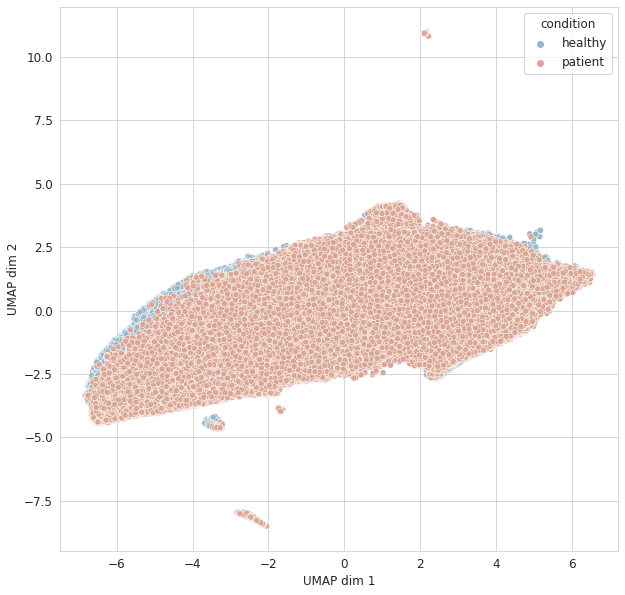

In [ ]:
umap = pd.read_csv("/content/umap_activated.csv")
sns.set_style("whitegrid")
markers = {"healthy": "s", "patient": "X"}
fig = plt.figure(figsize=(10, 10))

ax = sns.scatterplot(x="x", y="y", hue="condition",
                     data=umap, palette= colors, alpha = 1,legend = True)
ax.set(xlabel='UMAP dim 1', ylabel='UMAP dim 2')

fig = ax.get_figure()

plt.show()